# Принятие решений в бизнесе. A/B тестирование

**Цель проекта:**
Приоритизировать гипотезы, запустить A/B-тест, проанализировать результаты и вернуться с рекомендациями

**План исследования:**

1. Загрузить все необходимые библиотеки

2. Проверить на пропуски и дубликаты, при необходимости удалить строки, удаления которых не повлияет на итоговый результат

3. Изменить тип данных, привести к единому регистру

4. Проверить на аномальные значения

5. Приоритизировать гипотезы

6. Проанализировать результаты A/B-теста

7. Описать выводы и рекомендации

**Описания контекста:**

1. Проверила все таблицы на пропуски (метод info показал, что пропусков нет), дубликаты (отсутствуют), привела наименование столбцов датафрейма data к нижнему регистру для удобства, а также проверила таблицы на аномальные/отрицательные значения методом describe (отрицательных значений нет, аномальные есть - уберем их в процессе анализа А/В теста). А также проверила группы на наличие клиента в двух группах одновременно и на соотношения кол-ва клиентов в группах - незначительные отклонения.

2. Приоритизировала гипотезы методом ICE и RICE, выбрала топ-3 гипотез с учетом анализа двух методов.

3. Проанализировала результаты теста A/B по "сырым" и "очищенным" данным.

4. Описала вывод/результат теста

In [1]:
#загрузила библиотеки и датафреймы
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

In [2]:
#загрузила датафреймы
data = pd.read_csv('/datasets/hypothesis.csv')
orders, visitors = (
    pd.read_csv('/datasets/orders.csv'),
    pd.read_csv('/datasets/visitors.csv'),
)

**Вводная часть. Предобработка данных**

In [3]:
#проверила на пропуски и дубликаты
data.info()
orders.info()
visitors.info()
display(data.duplicated().sum())
display(orders.duplicated().sum())
visitors.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

0

0

0

**Вывод: пропусков и дубликатов нет**

In [4]:
#изменила тип данных и привела наименование столбцов к нижнему регистру.
#преобразовала к таймстемпу
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

data.columns = data.columns.str.lower()

In [5]:
#проверила на аномальные/отрицательные/нулевые значения
data.describe()

,reach,impact,confidence,efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


In [6]:
orders.describe()

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


In [7]:
visitors.describe()

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


**Вывод: Метод describe показал, что отрицательных/нулевых значений - нет, аномальные есть - уберем их в процессе анализа А/В теста**

In [8]:
display(orders.groupby('group').agg({'visitorId':'nunique'}))
orders['visitorId'].nunique()

,visitorId
group,
A,503
B,586


1031

**Вывод: есть незначительное кол-во клиентов, которые относятся к обеим группам. Группа В по кол-ву клиентов больше, необходимо это учитывать при анализе**

**Часть 1. Приоритизация гипотез**

In [9]:
#применила фреймворк ICE
data['ice'] = data['impact']*data['confidence']/data['efforts']
data_ice = data.sort_values(by='ice', ascending=False)
pd.options.display.max_colwidth = 130

data_ice

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


In [10]:
#применила фреймворк RICE

data['rice']=data['reach']*data['impact']*data['confidence']/data['efforts']
data_rice = data.sort_values(by='rice', ascending=False)
pd.options.display.max_colwidth = 130

data_rice

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


**Вывод: 
за счет объема пользователей, которых затронет изменение (компонент reach) приоритеты гипотез методом RICE изменились. А именно больше всего баллов набрала гипотеза 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок' вместо 'Запустить акцию, дающую скидку на товар в день рождения'. которая имела наивысший балл при методе ICE**

**С учетом анализа двух методов можно определить топ-3 гипотез:**
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
3. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	

**Часть 2. Анализ A/B-теста**

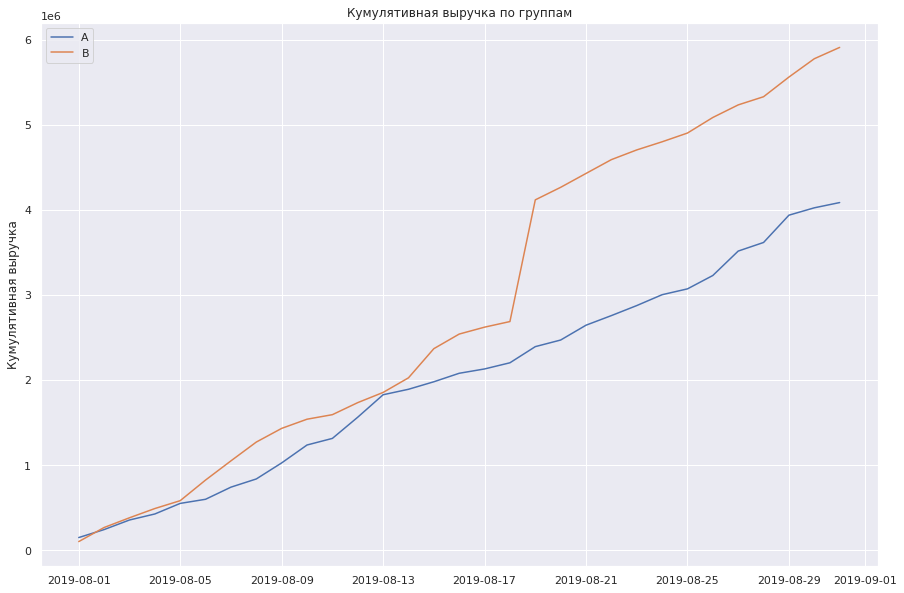

In [11]:
#построила график кумулятивной выручки по группам
OrdersGroupA = (
    orders[orders['group'] == 'A']
    .groupby('date', as_index = False)
    .agg({'transactionId': 'nunique', 'revenue':'sum'})
)

OrdersGroupA.columns = ['date', 'transactionIdPerA', 'revenuePerA']

OrdersACummulative = OrdersGroupA.apply(
    lambda x: OrdersGroupA[OrdersGroupA['date'] <= x['date']].agg (
        {'date':'max', 'transactionIdPerA':'sum', 'revenuePerA':'sum'}
),
    axis=1,
).sort_values(by=['date'])

OrdersACummulative.columns = ['date', 'transactionCummulativeA', 'revenueCummulativeA']

OrdersGroupB = (
    orders[orders['group'] == 'B']
    .groupby('date', as_index = False)
    .agg({'transactionId': 'nunique', 'revenue':'sum'})
)

OrdersGroupB.columns = ['date', 'transactionIdPerB', 'revenuePerB']

OrdersBCummulative = OrdersGroupB.apply(
    lambda x: OrdersGroupB[OrdersGroupB['date'] <= x['date']].agg (
        {'date':'max', 'transactionIdPerB':'sum', 'revenuePerB':'sum'}
),
    axis=1,
).sort_values(by=['date'])

OrdersBCummulative.columns = ['date', 'transactionCummulativeB', 'revenueCummulativeB']

plt.plot(OrdersACummulative['date'], OrdersACummulative['revenueCummulativeA'], label='A')
plt.plot(OrdersBCummulative['date'], OrdersBCummulative['revenueCummulativeB'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.ylabel('Кумулятивная выручка')
plt.legend()
plt.show()

**Вывод: накопительная выручка группы B значительно выше группы А, необходимо группу В проверить на выбросы, скорей всего 19 числа есть крупная покупка в группе B, которая значительно увеличивает результат**

In [12]:
#посмотрела сводную таблицу по всем продажам в разрезе группы А и В по дням
orders.pivot_table(index='date', columns='group', values='revenue', aggfunc='sum')

group,A,B
date,,
2019-08-01,148579,101217
2019-08-02,93822,165531
2019-08-03,112473,114248
2019-08-04,70825,108571
2019-08-05,124218,92428
2019-08-06,48484,242342
2019-08-07,142417,225334
2019-08-08,96279,220918
2019-08-09,188506,160812


In [13]:
#проверила на крупные покупки 19 августа
(
    orders.query('date == "2019-08-19"')
    .pivot_table(index='visitorId', columns='group', values='revenue', aggfunc='sum')
)

group,A,B
visitorId,,
154576532,NaN,26550.0
157579733,NaN,2330.0
290022471,NaN,16480.0
393266494,21550.0,NaN
492739583,750.0,NaN
517094627,390.0,NaN
522292794,NaN,4880.0
990904712,NaN,11249.0
1060341621,NaN,1100.0


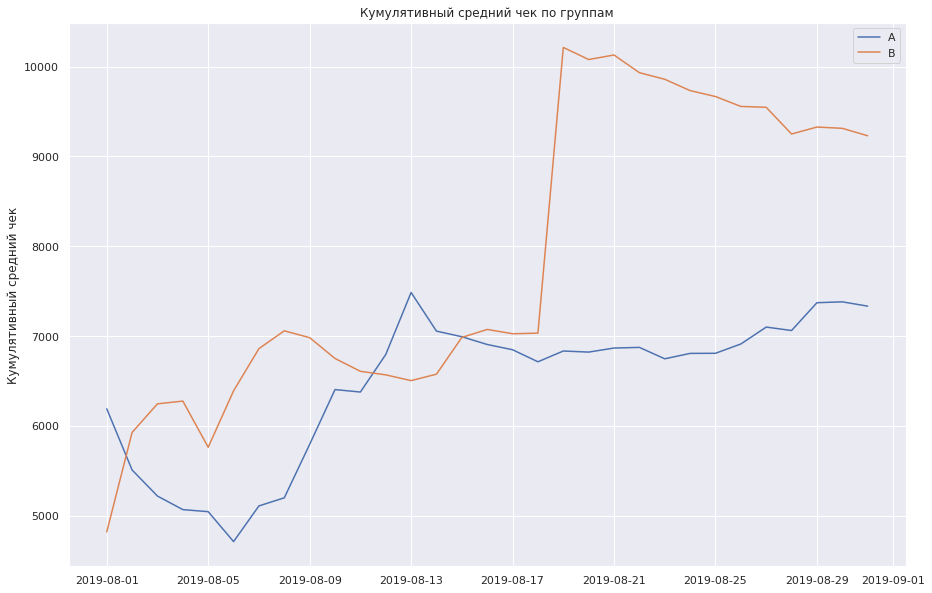

In [14]:
#построила график кумулятивного среднего чека по группам
OrdersACummulative['avg_checkA'] = round(OrdersACummulative['revenueCummulativeA']/OrdersACummulative['transactionCummulativeA'], 2)
OrdersBCummulative['avg_checkB'] = round(OrdersBCummulative['revenueCummulativeB']/OrdersBCummulative['transactionCummulativeB'], 2)

plt.plot(OrdersACummulative['date'], OrdersACummulative['avg_checkA'], label='A')
plt.plot(OrdersBCummulative['date'], OrdersBCummulative['avg_checkB'], label='B')
plt.title('Кумулятивный средний чек по группам')
plt.ylabel('Кумулятивный средний чек')
plt.legend()
plt.show()

**Вывод: До 17 числа тенденция по группам в принципе не отличалась, 19 чила резкий скачек среднего чека для группы В, но мы уже знаем почему**

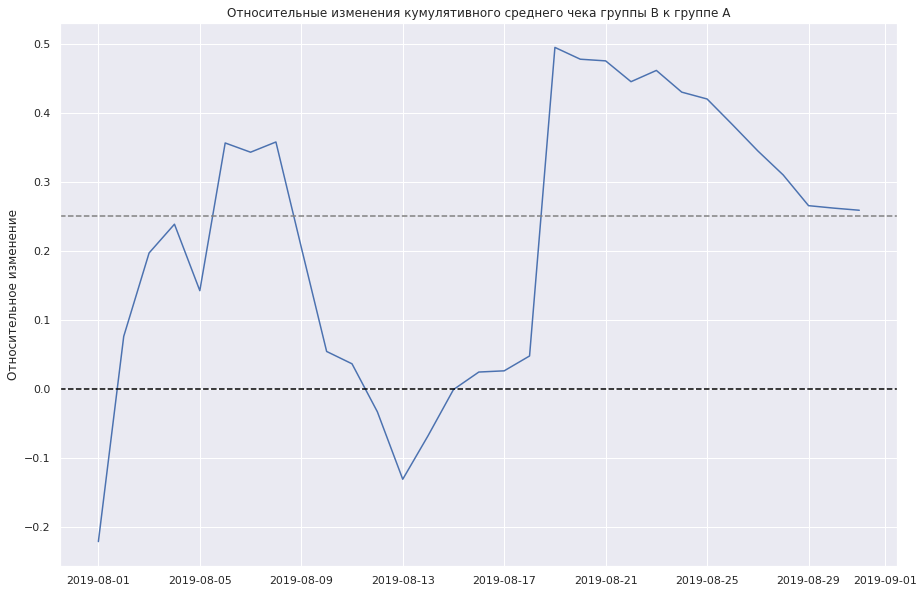

In [15]:
#постройте график относительного изменения кумулятивного среднего чека группы B к группе A
mergedCumulativeСheck = (
    OrdersACummulative[['date', 'avg_checkA']]
    .merge(OrdersBCummulative[['date', 'avg_checkB']], left_on='date', right_on='date', how='left')
)

plt.plot(mergedCumulativeСheck['date'], 
          mergedCumulativeСheck['avg_checkB']/mergedCumulativeСheck['avg_checkA'] - 1)
plt.title('Относительные изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel('Относительное изменение')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.25, color='grey', linestyle='--')
plt.show()

**Вывод: Почти с самого начала лидирует группа B по среднему чеку, хотя было такое, что и проваливалась, в конце теста группа B показала максимальный прирост около 50% относительно группы А и зафиксировалась в точке 25% прироста, что же будет после исключения выбросов**

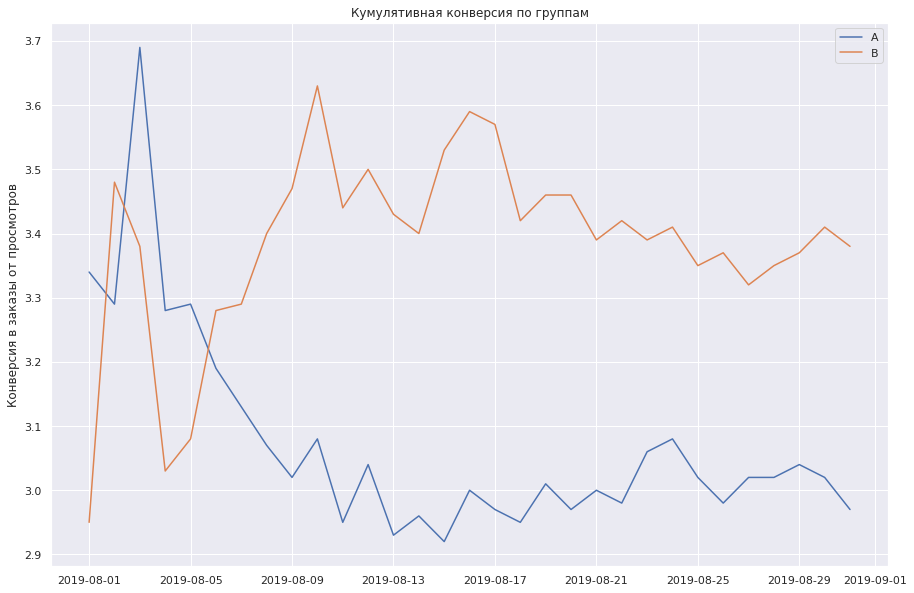

In [16]:
#построила график кумулятивной конверсии по группам
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
mergedCumulativeСonversions = visitorsAggregated.merge(ordersAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

mergedCumulativeСonversions['conversion'] = round(mergedCumulativeСonversions['transactionId']/mergedCumulativeСonversions['visitors'] * 100, 2)

mergedCumulativeСonversionsA = mergedCumulativeСonversions[mergedCumulativeСonversions['group']=='A']
mergedCumulativeСonversionsB = mergedCumulativeСonversions[mergedCumulativeСonversions['group']=='B']

plt.plot(mergedCumulativeСonversionsA['date'], mergedCumulativeСonversionsA['conversion'], label='A')
plt.plot(mergedCumulativeСonversionsB['date'], mergedCumulativeСonversionsB['conversion'], label='B')
plt.title('Кумулятивная конверсия по группам')
plt.ylabel('Конверсия в заказы от просмотров')
plt.legend()
plt.show()

In [17]:
#посчитала медианное значение конверсии группы А
mergedCumulativeСonversionsA.describe()

,visitors,transactionId,visitorId,revenue,conversion
count,31.000000,31.000000,31.000000,3.100000e+01,31.000000
mean,9860.419355,297.709677,270.354839,2.024356e+06,3.073226
std,5389.775529,160.361091,145.409892,1.209241e+06,0.160528
min,719.000000,24.000000,20.000000,1.485790e+05,2.920000
25%,5547.500000,169.000000,152.500000,9.313500e+05,2.975000
50%,10047.000000,301.000000,277.000000,2.078908e+06,3.020000
75%,14124.500000,433.500000,392.500000,2.938218e+06,3.080000
max,18736.000000,557.000000,503.000000,4.084803e+06,3.690000


In [18]:
#посчитала медианное значение конверсии группы В
mergedCumulativeСonversionsB.describe()

,visitors,transactionId,visitorId,revenue,conversion
count,31.000000,31.000000,31.000000,3.100000e+01,31.000000
mean,9906.193548,337.612903,313.451613,2.904626e+06,3.385484
std,5455.340084,184.922809,168.328417,1.932482e+06,0.146375
min,713.000000,21.000000,20.000000,1.012170e+05,2.950000
25%,5603.000000,192.500000,182.000000,1.350995e+06,3.360000
50%,10013.000000,359.000000,336.000000,2.539635e+06,3.400000
75%,14259.000000,485.000000,447.000000,4.750969e+06,3.460000
max,18916.000000,640.000000,586.000000,5.907760e+06,3.630000


**Вывод: конверсия в заказы от просмотров у группы В выше (около 3,4%), чем у группы А (около 3.0%)**

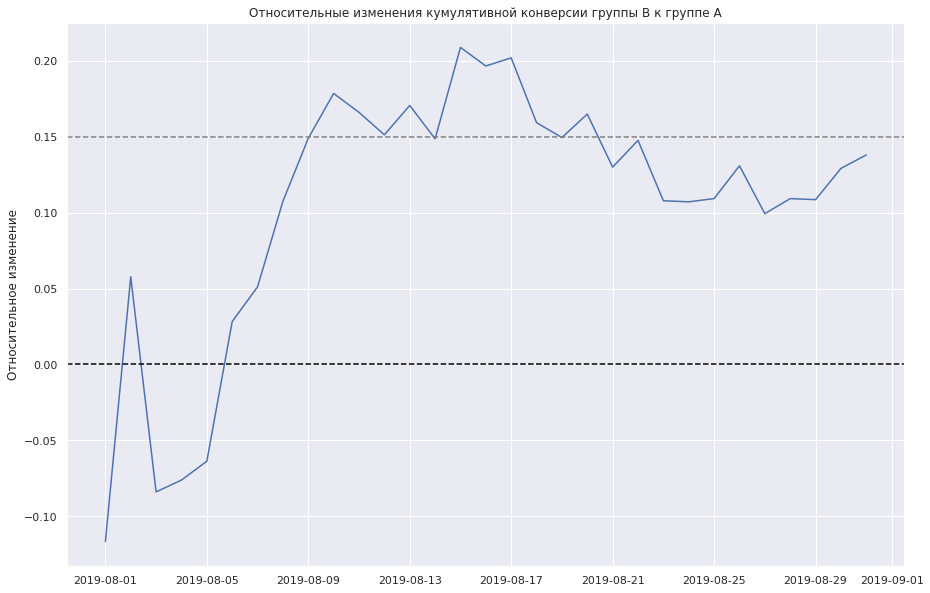

In [19]:
#построила график относительного изменения кумулятивной конверсии группы В к группе А
mergedCumulativeСonver = (
    mergedCumulativeСonversionsA[['date', 'conversion']]
    .merge(mergedCumulativeСonversionsB[['date', 'conversion']], left_on='date', right_on='date', how='left', suffixes=['A','B'])
)

plt.plot(mergedCumulativeСonver['date'], 
          mergedCumulativeСonver['conversionB']/mergedCumulativeСonver['conversionA']- 1)
plt.title('Относительные изменения кумулятивной конверсии группы B к группе A')
plt.ylabel('Относительное изменение')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.show()

**Вывод: группа В относително группы А имеет прирост по конверсии в среднем на 15%**

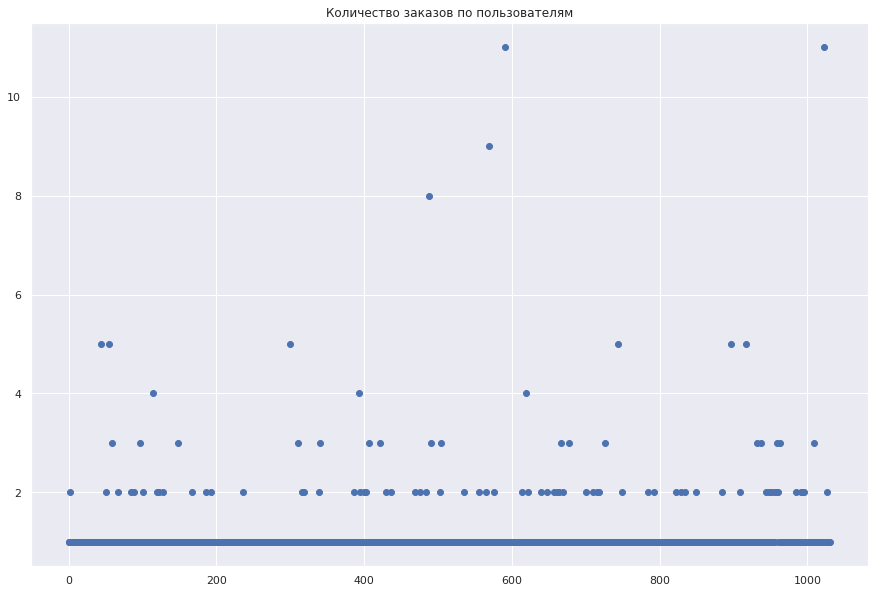

'95-й и 99-й перцентили количества заказов на пользователя:'

array([2., 4.])

In [20]:
#построила точечный график количества заказов по пользователям
#посчитала 95-й и 99-й перцентили количества заказов на пользователя
ordersUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg(
        {
            'group':'max',
            'transactionId': 'nunique',
            'revenue':'sum'
        }
    )
)

x_values = pd.Series(range(0, len(ordersUsers['transactionId'])))
plt.scatter(x_values, ordersUsers['transactionId'])
plt.title('Количество заказов по пользователям')
plt.show()

display('95-й и 99-й перцентили количества заказов на пользователя:', np.percentile(ordersUsers['transactionId'],[95, 99]))

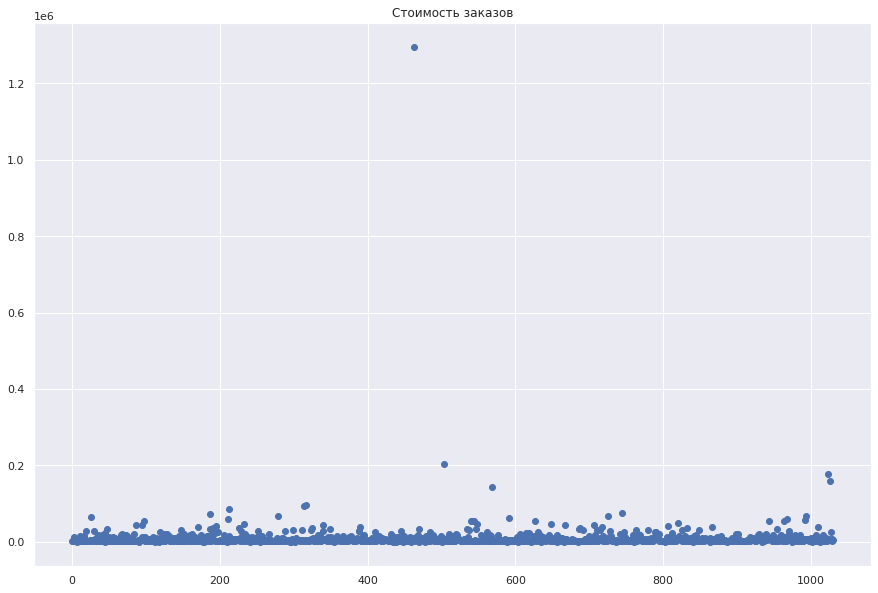

'95-й и 99-й перцентили стоимости заказов:'

array([32899.5, 67750. ])

In [21]:
#построила точечный график стоимостей заказов
#посчитала 95-й и 99-й перцентили стоимости заказов
x_values = pd.Series(range(0, len(ordersUsers['revenue'])))
plt.scatter(x_values, ordersUsers['revenue'])
plt.title('Стоимость заказов')
plt.show()

display('95-й и 99-й перцентили стоимости заказов:', np.percentile(ordersUsers['revenue'],[95, 99]))

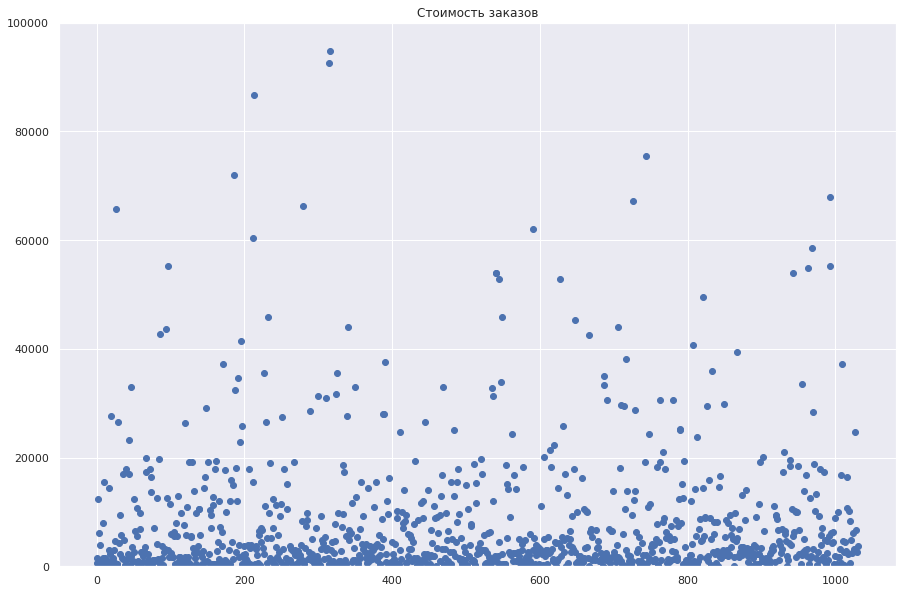

In [22]:
#посчитала точечный график стоимостей заказов, ограничив значения по оси Y
x_values = pd.Series(range(0, len(ordersUsers['revenue'])))
plt.scatter(x_values, ordersUsers['revenue'])
plt.ylim([0, 100000])
plt.title('Стоимость заказов')
plt.show()

**Вывод: Всё, как предполагали: есть пользователи, у которых число заказов выбивается, а также есть немного дорогих заказов. По обоим метрикам исключаем значения с 99-й перцентили**

**ПРОВЕРКА ГИПОТЕЗ**

**Нулевая гипотеза: статистически значимых различий в метрике между группами нет
Альтернативная гипотеза: статистически значимые различия в метрике между группами есть**

In [23]:
#посчитала статистическую значимость различий в конверсии между группами по «сырым» данным
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

sampleA=pd.concat(
    [
        ordersByUsersA['transactionId'],
        pd.Series(
            0, 
            index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['transactionId'])
            ), 
            name='transactionId'
        ),
    ],
    axis=0,
)

sampleB=pd.concat(
    [
        ordersByUsersB['transactionId'],
        pd.Series(
            0, 
            index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['transactionId'])
            ), 
            name='transactionId'
        ),
    ],
    axis=0,
)


display('p_value', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
display('Относительное изменение в средней конверсии группы В к группе А', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


'p_value'

'0.017'

'Относительное изменение в средней конверсии группы В к группе А'

'0.138'

In [24]:
ordersByUsersA 

,visitorId,transactionId
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1
...,...,...
498,4243832526,1
499,4256040402,7
500,4259830713,1
501,4266935830,1


**Вывод: По «сырым» данным различия в конверсии между группами A и B есть.
Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный выигрыш группы B равен 13.8% — второе число в выводе**

In [25]:
#посчитала статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
display('p_value','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
display('Относительное изменение в среднем чеке группы В к группе А',
        '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

'p_value'

'0.729'

'Относительное изменение в среднем чеке группы В к группе А'

'0.259'

**Вывод: По «сырым» данным различия в среднем чеке между группами A и B нет. Первое число — p-value = 0.72 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке нет, не отвергаем. Относительный выигрыш группы B равен 25.9% — второе число в выводе**

In [26]:
#очистила данные
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['transactionId'] > np.percentile(ordersUsers['transactionId'], 99)]['visitorId'],
        ordersByUsersB[ordersByUsersB['transactionId'] > np.percentile(ordersUsers['transactionId'], 99)]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(ordersUsers['revenue'], 99)]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

abnormalUsers.shape[0]

11

**Вывод: 11 аномальных пользователей**

In [27]:
#посчитала статистическую значимость различий в конверсии между группами по «очищенным» данным
sampleAFiltered=pd.concat(
    [
        ordersByUsersA[ 
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['transactionId'],
        pd.Series(
            0, 
            index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['transactionId'])
            ), 
            name='transactionId'
        ),
    ],
    axis=0,
)


sampleBFiltered=pd.concat(
    [
        ordersByUsersB[ 
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['transactionId'],
        pd.Series(
            0, 
            index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['transactionId'])
            ), 
            name='transactionId'
        ),
    ],
    axis=0,
)

display('p_value',"{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
display('Относительное изменение в средней конверсии группы В к группе А',"{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean() - 1))

'p_value'

'0.017'

'Относительное изменение в средней конверсии группы В к группе А'

'0.149'

**По "очищенным" данным вывод не изменился, статистические различия есть, плюс конверсия группы B относительно А выросла и достигла значения 14,9%**

In [28]:
#посчитала статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным
display(
    'p_value',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)
display(
    'Относительное изменение в среднем чеке группы В к группе А',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

'p_value'

'0.945'

'Относительное изменение в среднем чеке группы В к группе А'

'-0.041'

**По "очищенным" данным вывод не изменился, статистических различий нет, плюс после того, как убрали аномальные значения - группа B оказалась в проигрыше на 4%**

**Итоговый вывод: Остановить тест, зафиксировать победу группы B за счет конверсии, которая выше относительно группы А**

**Факты:**
1. Есть статистически значимые различия по конверсии между группами по «сырым» и по данным после фильтрации аномалий, группа В лучше на 14,9% по очищенным данным и в среднем конверсия составляет 3,4% (группа А - 3%)
2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.
При этом результат тестирования почти сравнялся (значение среднего чека) после исключения аномалий, в нашем случае чек на 1,3 млн и 140 тыс, которые только искажали картину и не несли ценности при тестировании